# 📘 Co jest "w środku"? - Tomografia komputerowa i uczenie głębokie
---
Ten notebook przedstawia teorię i praktykę tomografii komputerowej (CT) z punktu widzenia przetwarzania sygnałów (transformata Fouriera, Radona, Volume FT) oraz pokazuje, jak zastosować głębokie uczenie (CNN) do analizy obrazów CT.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os, random

# 📘 Analiza i rekonstrukcja tomografii komputerowej (CT) z perspektywy uczenia maszynowego


- [Czym jest tomografia komputerowa ct?](#Czym-jest-tomografia-komputerowa-ct) x
- [Reprezentacja sygnału ](#Reprezentacja-sygnału) x
- [Algorytm projekcji wstecznej](#Algorytm-projekcji-wstecznej) x
- [Fourier slice theorem](#Fourier-slice-theorem) x
- [Filtered backprojection](#Filtered-backprojection) x
- [Transformata Fouriera](#Transformata-Fouriera) y
- [Volume Fourier Transform – przejście do 3D](#volume-fourier-transform--przejscie-do-3d) y
- [Wizualizacja sinogramu i rekonstrukcji (kod praktyczny)](#wizualizacja-sinogramu-i-rekonstrukcji-kod-praktyczny) x
- [Bibliografia](#Bibliografia)


## Czym jest tomografia komputerowa (CT)?


<img src="images/Tomograf_wmw_sggw.jpg" width="100%">

Tomografia komputerowa to technika obrazowania medycznego służąca do uzyskiwania szczegółowych obrazów wnętrza ciała. Skanery TK wykorzystują obracającą się lampę rentgenowską i rząd detektorów umieszczonych w gantrze do pomiaru osłabienia promieniowania rentgenowskiego przez różne tkanki wewnątrz ciała. Wiele pomiarów promieniowania rentgenowskiego wykonanych pod różnymi kątami jest następnie przetwarzanych w komputerze przy użyciu algorytmów rekonstrukcji tomograficznej w celu uzyskania tomograficznych (przekrojowych) obrazów (wirtualnych „wycinków”) ciała. Badania TK mogą być stosowane u pacjentów z metalowymi implantami lub rozrusznikami serca, dla których rezonans magnetyczny (MRI) jest przeciwwskazany.
<br><br>
*Zbiór przekrojów 2D ludzkiego mózgu, uzyskany za pomocą tomografii komputerowej.* 
<br>
<img src="images/Slices.png" width="100%">

<br><br>

W przeciwieństwie do klasycznego zdjęcia rentgenowskiego, które nakłada na siebie wszystkie
warstwy ciała, tomografia komputerowa umożliwia uzyskanie **obrazów przekrojowych (ang. slices)** tzw. tomogramów,
czyli oddzielnych warstw wnętrza pacjenta — bez fizycznego rozcinania ciała. ( na szczescie ). <br>
Następnie obrazy są nakładane tworząc trójwymiarowy wokselowy tomogram obiektu.


<img src="gifs/ct_gen_fourth_gen.gif" width="100%">



---
### Fizyczna reprezentacja sygnału (do poprawy merytorycznej oraz kosmetycznej)
Podczas badania, lampa rentgenowska obraca się wokół pacjenta, a detektory mierzą intensywność promieniowania rentgenowskiego po jego przejściu przez ciało pod różnymi kątami. <br>
Jeżeli $I_0$ oznaczymy jako natężenie promieniowania wyemitowanego przez lampę a $I$ jako natężenie promieniowania wychwyconego przez detektor to te dwie wielkości można opisać zależnością Beera-Lamberta:
$$
I = I_0e^{-\int_L \mu(x, y)\, dl}
$$
gdzie $\mu (x, y)$ to "gęstość optyczna" w punkcie $(x,y)$ a $L$ to ścieżka promieniowania przez ciało. <br><br>
Zbiór całek $\int \mu (x) dx$ (odpowiadających $-\ln \frac{I}{I_0}$) jest odpowiedni dwuwymiarowej tzw. transformacie Radona czyli funkcji w przestrzeni lini $L \subset R^2$, która dla każdej pary ($\theta$ - kąt lini, $r$ - odległość lini od początku układu współrzędnych) przyporządkowuje całkę po tej lini na płaszczyźnie $\mu (x, y)$: 
$$
Rf(\theta , r) = \int_{-\infty}^{\infty} \mu (x(s), y(s))ds = \int_{-\infty}^{\infty} \mu ((s\sin \theta + r\cos \theta), (-s\cos \theta + r\sin \theta))ds 
$$
Takie dane tworzą tzw. sinogram: <br><br>
<img src="images/sinogram.jpeg" width="100%">
<br><br>
Aby otrzymać 2d tomogram musimy znaleźć transformację odwrotną:
$$
\mu (x, y) = R^{-1}\{Rf(\theta, r)\}
$$
<img src="images/Tomographic_fig1.png"  width="100%">

---
### Algorytm projekcji wstecznej (Backprojection).

Algorytm back projection polega na powrotnym nałożeniu na siebie wszystkich projekcji, po wcześniejszym ich przeskalowaniu:
$$
    f_{bp}(x, y) = \int_0^{\pi}Rf(\theta, x\cos\theta + y\sin\theta)d\theta
$$
Tutaj prosty skrypt (credits: chatgpt), który wizualizuje algorytm projekcji wstecznej (parametry są modyfikowalne):


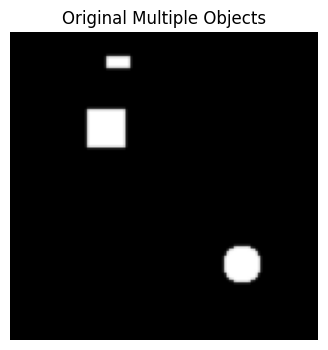
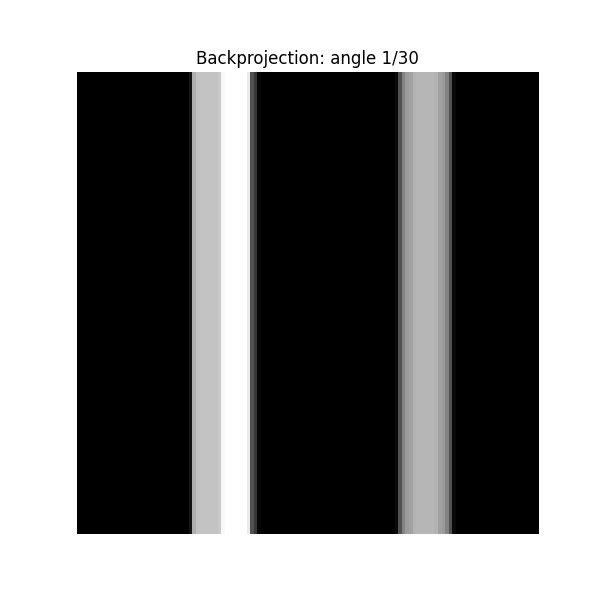
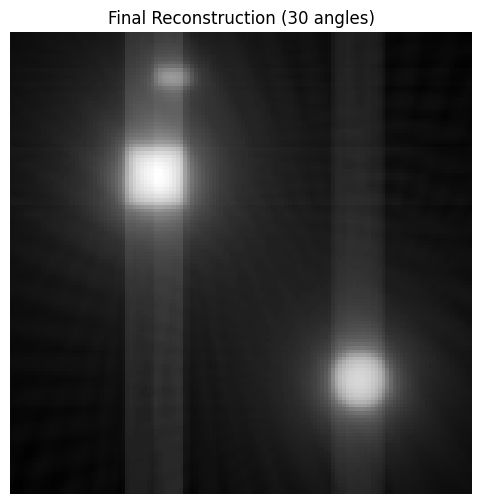

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate, gaussian_filter
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import display, HTML

# -----------------------------
# Parameters
# -----------------------------
image_size = 128
num_angles = 30
num_rays = 128
save_gif = "backprojection_multiple_objects.gif"

# -----------------------------
# Create multiple objects
# -----------------------------
object_img = np.zeros((image_size, image_size))

# Object 1: square
object_img[image_size//4:3*image_size//8, image_size//4:3*image_size//8] = 1

# Object 2: circle
cx, cy = int(3*image_size/4), int(3*image_size/4)
r = 8
for i in range(image_size):
    for j in range(image_size):
        if (i-cy)**2 + (j-cx)**2 < r**2:
            object_img[i,j] = 1

# Object 3: small rectangle
object_img[10:15, 40:50] = 1

# Optional: smooth edges
object_img = gaussian_filter(object_img, sigma=0.5)

# -----------------------------
# Compute projections
# -----------------------------
angles = np.linspace(0, 180, num_angles, endpoint=False)
projections = np.zeros((num_angles, num_rays))

for i, theta in enumerate(angles):
    rotated = rotate(object_img, theta, reshape=False, order=1)
    projection = np.sum(rotated, axis=0)
    projections[i] = np.interp(np.linspace(0, image_size-1, num_rays),
                               np.arange(image_size), projection)

# -----------------------------
# Backprojection animation (centered)
# -----------------------------
reconstruction = np.zeros((image_size, image_size))

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(reconstruction, cmap='gray', vmin=0, vmax=1)
ax.axis('off')
ax.set_title("Backprojection in Progress")

# Center coordinates
x = np.arange(image_size) - image_size/2
y = np.arange(image_size) - image_size/2
X, Y = np.meshgrid(x, y)

def update(frame):
    global reconstruction
    theta = angles[frame]
    t = X * np.cos(np.deg2rad(theta)) + Y * np.sin(np.deg2rad(theta))
    t_scaled = (t + image_size/2) * (num_rays / image_size)
    t_scaled = np.clip(t_scaled, 0, num_rays-1)
    reconstruction += np.interp(t_scaled.flatten(), np.arange(num_rays), projections[frame]).reshape(image_size, image_size)
    im.set_data(reconstruction / reconstruction.max())
    ax.set_title(f"Backprojection: angle {frame+1}/{num_angles}")
    return [im]

ani = FuncAnimation(fig, update, frames=num_angles, blit=True)
ani.save(save_gif, writer=PillowWriter(fps=5))
plt.close(fig)

import base64

# Convert matplotlib image to base64
import matplotlib.pyplot as plt
import io

def plt_to_base64(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    img_bytes = buf.read()
    base64_str = base64.b64encode(img_bytes).decode('utf-8')
    plt.close(fig)
    return base64_str

# 1. Original object image
fig1 = plt.figure(figsize=(4,4))
plt.title("Original Multiple Objects")
plt.imshow(object_img, cmap='gray')
plt.axis('off')
img1_base64 = plt_to_base64(fig1)

# 2. Final reconstruction
fig2 = plt.figure(figsize=(6,6))
plt.title(f"Final Reconstruction ({num_angles} angles)")
plt.imshow(reconstruction / reconstruction.max(), cmap='gray')
plt.axis('off')
img2_base64 = plt_to_base64(fig2)

# 3. GIF file (convert to base64)
with open(save_gif, "rb") as f:
    gif_base64 = base64.b64encode(f.read()).decode('utf-8')

# Display all horizontally
html_str = f"""
<div style="display:flex; align-items:center; gap:20px;">
    <div>
        <img src="data:image/png;base64,{img1_base64}" width="400"><br>
        <p style="text-align:center;">Original Multiple Objects</p>
    </div>
    <div>
        <img src="data:image/gif;base64,{gif_base64}" width="400"><br>
        <p style="text-align:center;">GIF Animation</p>
    </div>
    <div>
        <img src="data:image/png;base64,{img2_base64}" width="400"><br>
        <p style="text-align:center;">Final Reconstruction</p>
    </div>
</div>
"""

display(HTML(html_str))

Jak widać, naiwna rekonstrukcja nie umożliwia odzyskania oryginalnego obrazu. Obraz jest rozmyty przez nadreprezentację niskich częstotliwości w sinogramie.

---
## Problem Backprojection

Niestety naiwne backprojection nie umożliwia rekonstrukcji obrazu wysokiej jakości. Aby to zrozumieć trzeba zrozumieć czym jest transformacja Fouriera (tu odnośnik do drugiego notebooka?).
<br>
<br>

Obrazy są rozmyte, ponieważ po rekonstrukcji $f_{bp}$ niższe częstotliwości są nadreprezentowane w widmie naszego tomogramu:
$$
 \mathcal{F_2}\{f_{bp}\}(\Omega_1, \Omega_2) = \frac{2\pi}{|\omega|}F(\Omega_1, \Omega_2)
$$
gdzie:<br>
$\mathcal{F_2}$ - 2d operator transformacji Fouriera.<br>
$F$ - 2d transformata Fouriera oryginalnej funkcji $\mu$ <br>
$\omega = \sqrt{\Omega_1^2 + \Omega_2^2}$<br><br>

Jak widać, amplituda częstotliwości niskich (bliskie zeru) jest wzmacniana a wysokich - wygłuszana (czynnik $\frac{1}{|\omega|}$). <br><br>

Powyższe wnioski prowadzą nas do algorytmu filtered backprojection ale wcześniej musimy zrozumieć fourier slice theorem.

## Fourier slice theorem

Załóżmy, że mamy 2d funkcję $f(x,y)$ i: <br>
$\mathcal{F_1}$ oraz $\mathcal{F_2}$ - odpowiednio 1d oraz 2d operator transformacji fouriera. <br>
$P_1$ - operator projekcji z przestrzeni 2d na linię (np transformacja radona). <br>
$S_1$ - operator przekroju (slice operator). Wycina tą samą linię z funkcji 2d.<br>

Fourier slice theorem mówi że:
$$
        F_1P_1 = S_1F_2
$$
Czyli transformata Fouriera projekcji funkcji dwuwymiarowej na prostą odpowiada przekrojowi dwuwymiarowej transformaty Fouriera tej funkcji wzdłuż tej samej prostej.<br>

_Dowód:_ <br>
weźmy $f(x,y)$ i jej projekcję $p(x)$ na oś x daną wzorem:
$$
        p(x) = \int_{-\infty}^{\infty}f(x,y)dy
$$
Transformata funkcji $f$ to:
$$
F(\Omega_x, \Omega_y) = \int_{-\infty}^{\infty}\int_{-\infty}^{\infty}f(x,y)e^{-2\pi i(x\Omega_x + y\Omega_y)}dxdy
$$
Nasz przekrój $s(\Omega_x)$ to:
$$
s(\Omega_x) = F(\Omega_x, 0) = \int_{-\infty}^{\infty}\int_{-\infty}^{\infty}f(x,y)e^{-2\pi ix\Omega_x}dxdy \\
= \int_{-\infty}^{\infty}\left[\int_{-\infty}^{\infty}f(x,y)dy\right]e^{-2\pi ix\Omega_x}dx \\
= \int_{-\infty}^{\infty}p(x)e^{-2\pi ix\Omega_x}dx
$$
Co jest równe transformacie $\mathcal{F_1}\{p\}$. <br><br><br>


---

## Filtered backprojection

W tym rozdziale wyprowadzimy wzór na algorytm filtered backprojection (filtrowana projekcja wsteczna?). <br>
Przypomnijmy: <br>



---

### 📊 Wynik

Wynikiem tomografii komputerowej jest **seria przekrojów 2D** (ang. *slices*), które po zestawieniu dają **model 3D** wnętrza organizmu.
Każdy piksel odpowiada określonemu poziomowi osłabienia promieniowania (w jednostkach **Hounsfielda**, HU):

| Tkanka | Wartość HU (przykład) |
|--------|-----------------------|
| Powietrze | -1000 |
| Płuca | -500 |
| Tkanka miękka | 30–70 |
| Kość | +1000 |


# Reprezentacja sygnału


Obraz jako funkcja!!!!

Nasz obraz można zapisać jako funkcję dwóch zmiennych — jego jasności w każdym punkcie:

$$
f(x, y) = \text{jasność piksela w punkcie } (x, y)
$$

W obrazie w odcieniach szarości \( f(x, y) \) przyjmuje wartości np. od **0 (czarny)** do **255 (biały)**,
a dla obrazów kolorowych mamy trzy funkcje: \( f_R(x, y), f_G(x, y), f_B(x, y) \).

Każdy piksel jest więc **próbką funkcji** opisującej rozkład intensywności w przestrzeni.

---

# Świat jest falowy 🌊

Światło, dźwięk, drgania, pole elektromagnetyczne, nawet sygnały w neuronach —
**wszystko rozchodzi się jak fale**.

Dlatego analiza Fouriera działa tak dobrze —
bo transformata Fouriera to po prostu **matematyka fal**.

Gdy robisz Fouriera na obrazie, przechodzisz do tego samego języka,
w którym działa **fizyka Twojego czujnika (np. kamery, mikrofonu, detektora CT)**.

## Transformata Fouriera



---

# Zasada podstawowa transformaty Fouriera

Zasadniczo:
> Fourier pokazał, że **funkcje sinusoidalne tworzą bazę przestrzeni funkcji**.

To znaczy, że dowolną funkcję (jeśli nie jest zupełnie „dzika”) można zapisać jako **sumę fal o różnych częstotliwościach**:

$$
f(x) = \int_{-\infty}^{+\infty} F(k) \, e^{i 2\pi kx} \, dk
$$

### Gdzie:

- $ e^{i 2\pi kx} $ fala o częstotliwości \( k \),
- \( F(k) \) – „ile” tej fali jest w sygnale,
- całka – to po prostu **suma wszystkich fal**.

---

## 4️⃣ Intuicja

Fale $ e^{i 2\pi kx} $ tworzą **pełny i ortogonalny zestaw** —
żadna nie jest powtórzeniem innej,
a razem pokrywają **całą możliwą przestrzeń funkcji**.

To tak, jak zestaw **„podstawowych dźwięków”**,
z których da się odtworzyć **każdą "melodię"**.

---

$$
\boxed{
f(x) = \int_{-\infty}^{+\infty} F(k) \, e^{i 2\pi kx} \, dk
\quad\text{i odwrotnie}\quad
F(k) = \int_{-\infty}^{+\infty} f(x) \, e^{-i 2\pi kx} \, dx
}
$$

---

✨ **Wniosek:**
Transformata Fouriera to sposób na zapisanie obrazu lub sygnału w języku fal —
czyli dokładnie tym języku, w którym opisuje się **świat fizyczny**.

---

---


Transformata Fouriera to jedno z najważniejszych narzędzi w analizie sygnałów.
Pozwala przedstawić sygnał (np. obraz) nie w dziedzinie przestrzeni, ale **w dziedzinie częstotliwości**,
czyli pokazać, z jakich składowych (częstotliwości, fal) jest zbudowany.

Dla obrazu 2D transformata Fouriera ma postać:

$$
F(u, v) = \int\!\!\int f(x, y) \, e^{-j2\pi(ux + vy)} \, dx \, dy
$$

gdzie:
- $f(x,y)$ — obraz w dziedzinie przestrzennej (np. przekrój z tomografii),
- $F(u,v)$ — jego reprezentacja w dziedzinie częstotliwości,
- $(u,v)$ — częstotliwości przestrzenne.

---

### 💡 Dlaczego jest to ważne w tomografii i ML?

- W tomografii komputerowej (CT) każda **projekcja 2D** zawiera informacje o częstotliwościach wnętrza obiektu.
  Dzięki **twierdzeniu projekcyjnemu (Fourier Slice Theorem)** można zrekonstruować pełny obraz z jego widma.

- W uczeniu maszynowym znajomość transformaty Fouriera pomaga zrozumieć:
  - jak sieci konwolucyjne (CNN) reagują na różne częstotliwości w obrazie,
  - dlaczego filtry uczone przez sieć działają jak „lokalne” wersje transformacji Fouriera,
  - jak eliminować szum (filtracja częstotliwościowa) lub poprawiać jakość rekonstrukcji.

---

📘 **W skrócie:**
Transformata Fouriera pokazuje, *z jakich wzorców przestrzennych (częstotliwości)* zbudowany jest obraz —
i stanowi podstawę zarówno dla **rekonstrukcji CT**, jak i **analizy cech w sieciach neuronowych (CNN)**.


## Volume Fourier Transform – przejście do 3D

W tomografii komputerowej celem jest odtworzenie **trójwymiarowego rozkładu osłabienia promieniowania**
wewnątrz obiektu, czyli funkcji $\mu(x, y, z)$.

Aby opisać takie dane w dziedzinie częstotliwości, stosuje się **trójwymiarową transformatę Fouriera** (*Volume Fourier Transform*), zdefiniowaną jako:

$$
F(u, v, w) = \iiint f(x, y, z) \, e^{-j2\pi(ux + vy + wz)} \, dx \, dy \, dz
$$

gdzie:
- $f(x,y,z)$ — funkcja reprezentująca wnętrze obiektu (np. gęstość tkanek),
- $F(u,v,w)$ — jej reprezentacja w dziedzinie częstotliwości,
- $(u,v,w)$ — częstotliwości przestrzenne w trzech wymiarach.

---

### 🧩 Intuicja

Każda **projekcja 2D** (obraz CT pod określonym kątem) odpowiada **płaszczyźnie** w przestrzeni częstotliwości $(u,v,w)$.
Zbierając wiele projekcji pod różnymi kątami, wypełniamy tę przestrzeń i możemy odtworzyć pełną strukturę 3D poprzez **odwrotną transformację Fouriera**.

---

### 💡 Znaczenie w uczeniu maszynowym

- Modele oparte na **3D CNN** lub **U-Net 3D** w zadaniach medycznych uczą się działać w przestrzeni, która odpowiada takiej reprezentacji objętościowej.
- W nowoczesnych podejściach (np. *NeRF*, *Fourier Feature Mapping*) sygnały 3D reprezentuje się również w przestrzeni częstotliwości, aby lepiej modelować zależności przestrzenne.
- W **DL-CT** (deep learning computed tomography) sieć może nauczyć się bezpośrednio odwrotnego odwzorowania z płaszczyzn projekcji do przestrzeni 3D, omijając jawne obliczanie transformacji Fouriera.

---

📘 **W skrócie:**
Transformata Fouriera w 3D (Volume Fourier Transform) opisuje, jak rozkładają się częstotliwości w całej objętości —
i stanowi podstawę matematyczną rekonstrukcji trójwymiarowych struktur w tomografii komputerowej.


## Struktura 3D rekonstruowana z wielu 2D projekcji – transformacja Radona i algorytmy rekonstrukcji odwrotnej

Tomografia komputerowa pozwala odtworzyć **trójwymiarową strukturę wnętrza obiektu** na podstawie wielu
**dwuwymiarowych projekcji (obrazów RTG)** uzyskanych pod różnymi kątami.

Każda taka projekcja rejestruje całkę z funkcji osłabienia $\mu(x, y, z)$ wzdłuż promienia przechodzącego przez obiekt.
Z matematycznego punktu widzenia jest to **transformacja Radona**.

---

### 🧩 Transformacja Radona

Transformacja Radona dla obrazu 2D $f(x,y)$ jest zdefiniowana jako:

$$
p_\theta(s) = \int f(x, y)\,\delta(x\cos\theta + y\sin\theta - s)\,dx\,dy
$$

- $p_\theta(s)$ — projekcja (pomiar CT) pod kątem $\theta$,
- $\delta(\cdot)$ — funkcja Diraca, która „wybiera” punkty leżące na linii projekcji,
- $s$ — pozycja detektora dla danej projekcji.

Zestaw wszystkich projekcji dla różnych kątów $\theta$ tworzy **sinogram** — reprezentację wszystkich danych pomiarowych CT.

---

### 🔄 Rekonstrukcja odwrotna (Inverse Radon Transform)

Aby odzyskać oryginalny obraz $f(x, y)$ (lub strukturę 3D $\mu(x, y, z)$), wykonuje się **odwrotną transformację Radona**.
Najczęściej stosowany algorytm to **Filtered Backprojection (FBP)**:

$$
f(x, y) = \int_0^{\pi} \mathcal{F}^{-1}\{|\omega| P_\theta(\omega)\}\big(x\cos\theta + y\sin\theta\big)\,d\theta
$$

czyli:
1. każda projekcja $p_\theta(s)$ jest filtrowana w dziedzinie Fouriera przez $|\omega|$,
2. następnie „rozsuwana” (backprojection) po wszystkich kątach, tworząc pełen obraz.

---

### 🧠 Intuicja

- Każda **projekcja 2D** wnosi część informacji o wnętrzu obiektu wzdłuż konkretnego kierunku.
- Sumując projekcje z wielu kątów, otrzymujemy kompletny opis przestrzeni — czyli **rekonstrukcję 3D**.
- W praktyce komputer wykonuje setki lub tysiące takich operacji, by uzyskać objętość $f(x, y, z)$.

---

### 💡 Związek z uczeniem głębokim

Nowoczesne modele (np. *FBPConvNet*, *Learned Primal-Dual*, *Neural Radon Inversion*) uczą się **aproksymować transformację odwrotną Radona**,
zastępując klasyczne filtry i całki funkcjami uczonymi przez sieć neuronową.

Dzięki temu można rekonstruować obrazy o wysokiej jakości nawet z **niepełnych danych** (np. z mniejszej liczby projekcji, mniejszą dawką promieniowania).

---

📘 **W skrócie:**
Struktura 3D wnętrza obiektu jest odtwarzana z wielu 2D projekcji dzięki transformacji Radona i algorytmom rekonstrukcji odwrotnej.
To właśnie ten proces pozwala „zajrzeć do środka” bez naruszania obiektu — zarówno w klasycznej tomografii, jak i we współczesnych modelach deep learningowych.


## Bibliografia

- https://www.udemy.com/course/deep-learning-with-pytorch-for-medical-image-analysis/?couponCode=ACCAGE0923




- https://www.youtube.com/watch?v=WxH5bDzMWjg
- https://www.youtube.com/watch?v=f0sxjhGHRPo
- https://www.youtube.com/watch?v=FK4R3waARm8&list=PLldiDnQu2phsW7fsuLW3zmFBSjHItdGXi
- https://www.youtube.com/watch?v=pZ7JlXagT0w
- https://www.youtube.com/watch?v=YIvTpW3IevI
- https://www.youtube.com/watch?v=cSIkpgvio-8
- https://www.youtube.com/watch?v=dn358iX_WxQ






- Principles of Computerized Tomographic Imaging —  (Kak & Slaney) : https://www.mat.uniroma2.it/~picard/SMC/didattica/materiali_did/Anal.Armon./Principles_of_CT_Imaging/Kak&Slaney-CTI-reduced.pdf
- Stabilizing Deep Tomographic Reconstruction : https://arxiv.org/pdf/2008.01846
- DeepLung: Deep 3D Dual Path Nets for
Automated Pulmonary Nodule Detection and Classification : https://arxiv.org/pdf/1801.09555


- honorable mention : Chat GPT
